# Problem Set 7

Iris Lan

In [82]:
import math, kplr
from my_transit import FluxRatio
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.integrate import simps
%matplotlib inline

In [96]:
# Find the target KOI.
client = kplr.API()
koi = client.koi(97.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Open the first dataset and read it
file = lcs[0].open()
hdu_data = file[1].data
time = hdu_data["time"]  # get the time of each observation
flux = hdu_data["sap_flux"] # get the flux
ferr = hdu_data["sap_flux_err"] # get the error in the flux
file.close()

# store data in a table
KOI = Table([time, flux, ferr], names = ('time', 'flux', 'ferr'))
# KOI.show_in_notebook()

## Problem 1

extract the data in the time range 124 < t < 125

In [97]:
eidx = np.intersect1d(np.where(time <= 125.0), np.where(time >= 124.0))
time = time[eidx]
flux = flux[eidx]
ferr = ferr[eidx]

get $\overline{F}^\prime,\overline{\sigma}^\prime $

In [125]:
def normalize(f, n):
    
    def two_sigma_clipping(flux):
        F_p, sigma_p = np.mean(flux), np.std(flux)
        idx = np.where(abs(flux - F_p) / sigma_p <= 2)
        return flux[idx]
    
    i = 0
    while i < n:
#         print(i)
        f = two_sigma_clipping(f)
        i += 1
    
    return np.mean(f), np.std(f)

normalize flux and error with $\overline{F}^\prime,\overline{\sigma}^\prime $

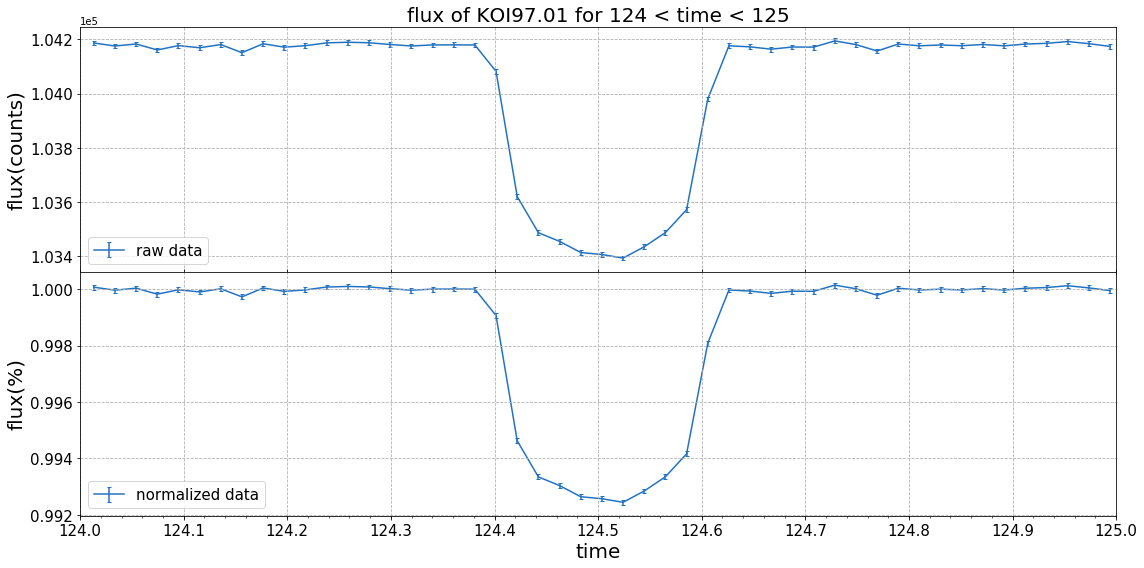

In [126]:
F_p, sigma_p = normalize(flux, 5)
nflux, nerr = flux / F_p, ferr / F_p

fig1, (axu, axb) = plt.subplots(2, 1, sharex = True, sharey = False, figsize = (16, 8))

axu.errorbar(time, flux, yerr = ferr, 
             fmt = '-', capsize = 2, c = '#2172C3', label = 'raw data', zorder = 1)
axb.errorbar(time, nflux, yerr = nerr, 
             fmt = '-', capsize = 2, c = '#2172C3', label = 'normalized data', zorder = 1)

for ax in (axu, axb):
    ax.grid(ls = '--')
    ax.legend(loc = 3, fontsize = 15)
    ax.tick_params(axis = 'both', labelsize = 15)
    
axu.tick_params(axis = 'x', direction = 'in')
axu.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0, 0), fontsize = 15)
axu.set_ylabel('flux(counts)', size = 20)
axu.set_title('flux of KOI97.01 for 124 < time < 125', fontsize = 20)

axb.set_xlim(124.0, 125.0)
axb.set_xlabel('time', size = 20)
axb.xaxis.set_major_locator(xmajorLocator)
axb.xaxis.set_minor_locator(xminorLocator)
axb.set_ylabel('flux(%)', size = 20)

fig1.tight_layout()
fig1.subplots_adjust(hspace = 0.0)

define all the functions

In [123]:
def z_func(t, t_0, tau):
    '''convert time to z'''
    return (t - t_0) / tau
z_func = np.vectorize(z_func)

def Flux_simpson(p, z, **kwargs):
    def simpson(func, x1, x2, N, **kwargs):
        delta_x = (x2 - x1) / N
        x = np.linspace(x1, x2, num = N)
        x_mid = (x[1:] + x[:-1]) / 2 # mid-points of each pair

        result = func(x[0], **kwargs) / 6 + func(x[-1], **kwargs) / 6
        for x_i in x:
            result += func(x_i, **kwargs) / 3

        for x_mid_i in x_mid:
            result += 2 / 3 * func(x_mid_i, **kwargs)

        return delta_x * result
    
    def func1(r, p, z):
        '''the numerator'''
        return I(r) * FluxRatio(p, z) * 2 * r

    def func2(r, p, z):
        '''the denominator'''
        return I(r) * 2 * r
    
    def I(r):
        '''A Limb-darkening functionm, r = sin(theta)'''
        mu = (1 - (r**2))**(0.5)
        return 1 - (1 - (mu**(0.5)))
    
    numerator   = simpson(func1, p = p, z = z, **kwargs)
    denominator = simpson(func2, p = p, z = z, **kwargs)
    
    return numerator / denominator
Flux = np.vectorize(Flux_simpson)

def chi_square(y, fit, sigma):
    return np.sum(((y - fit) / sigma)**2)

fit the light curve with with $p = 0.0775, t_0 = 124.51, \tau = 0.1$ and compute the $\chi^2$

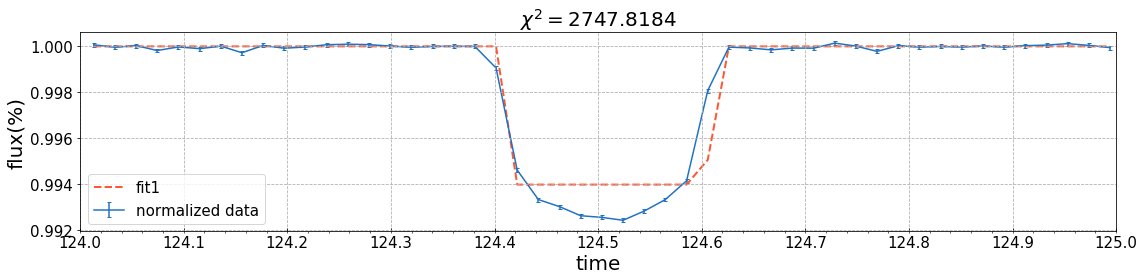

In [131]:
fit1 = Flux(p = 0.0775, z = z(time, t_0 = 124.51, tau = 0.1), N = 1000, x1 = 0.0, x2 = 1.0)
chi2_1 = chi_square(nflux, fit1, nerr)

fig2, ax2 = plt.subplots(figsize = (16, 4))

ax2.errorbar(time, nflux, yerr = nerr, 
             fmt = '-', capsize = 2, c = '#2172C3', label = 'normalized data', zorder = 1)
ax2.plot(time, fit1, 
             ls = '--', lw = 2, c = '#FF5733', label = 'fit1', zorder = 1)

ax2.grid(ls = '--')
ax2.legend(loc = 3, fontsize = 15)
ax2.tick_params(axis = 'both', labelsize = 15)
    
ax2.tick_params(axis = 'x', direction = 'in')
ax2.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0, 0), fontsize = 15)
ax2.set_ylabel('flux(counts)', size = 20)
ax2.set_title('$\chi^2 = %.4f$' % chi2_1, fontsize = 20)

ax2.set_xlim(124.0, 125.0)
ax2.set_xlabel('time', size = 20)
ax2.xaxis.set_major_locator(xmajorLocator)
ax2.xaxis.set_minor_locator(xminorLocator)
ax2.set_ylabel('flux(%)', size = 20)

fig2.tight_layout()
fig2.subplots_adjust(hspace = 0.0)

## Problem 2